In [1]:
import os
os.chdir(os.path.expanduser("~/Projects/zimmer"))
import copy
import pickle

import numpy as np
np.random.seed(1234)

from scipy.stats import multivariate_normal

import matplotlib.pyplot as plt
import matplotlib.cm
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn
seaborn.set_style("white")
seaborn.set_context("paper")

plt.ion()

from tqdm import tqdm
from functools import partial

from zimmer.io import load_nichols_data
import zimmer.plotting as zplt
from zimmer.util import cached

from ssm.util import find_permutation, compute_state_overlap
from ssm.preprocessing import pca_with_imputation, trend_filter, standardize

In [60]:
# Specify hyperparameters
D = 10   # dimensionality of continuous latent states
M = 0    # dimensionality of input
results_dir = "results/nichols/2018-09-26/D{}".format(D)
figures_dir = os.path.join(results_dir, "figures")

In [3]:
groups = ["n2_1_prelet", 
          "n2_2_let",
          "npr1_1_prelet",
          "npr1_2_let"]

worms_and_groups = [(i, "n2_1_prelet") for i in range(11)] + \
                   [(i, "n2_2_let") for i in range(12)] + \
                   [(i, "npr1_1_prelet") for i in range(10)] + \
                   [(i, "npr1_2_let") for i in range(11)]
worm_names = ["{} worm {}".format(group, i) for (i, group) in worms_and_groups]

In [4]:
# Load the data
ys, ms, us, z_trues, z_true_key, neuron_names = load_nichols_data(worms_and_groups, worm_names, include_unnamed=False, signal="dff")

Only including named neurons.
73 neurons across all 44 worms


In [5]:
ys = [trend_filter(y) for y in ys]
# ys = [standardize(y, m) for y, m in zip(ys, ms)]
K_true = len(z_true_key)
N = ys[0].shape[1]
W = len(ys)
Ts = [y.shape[0] for y in ys]

In [6]:
# Split into train and test
chunk = 250
train_frac = 0.7
val_frac = 0.15
all_ys = []
all_ms = []
all_choices = []
for y, m in zip(ys, ms):
    T = y.shape[0]
    C = 0
    for start in range(0, T, chunk):
        stop = min(start+chunk, T)
        all_ys.append(y[start:stop])
        all_ms.append(m[start:stop])
        C += 1
        
    # assign some of the data to train, val, and test
    choices = -1 * np.ones(C)
    choices[:int(train_frac * C)] = 0
    choices[int(train_frac * C):int((train_frac + val_frac) * C)] = 1
    choices[int((train_frac + val_frac) * C):] = 2
    choices = choices[np.random.permutation(C)]
    all_choices.append(choices)

all_choices = np.concatenate(all_choices)
get = lambda arr, chc: [x for x, c in zip(arr, all_choices) if c == chc]

train_ys = get(all_ys, 0)
train_ms = get(all_ms, 0)

val_ys = get(all_ys, 1)
val_ms = get(all_ms, 1)

test_ys = get(all_ys, 2)
test_ms = get(all_ms, 2)

# Empirical correlation

In [7]:
def compute_covariance():
    C = np.nan * np.ones((N, N))
    
    for i in range(N):
        for j in range(N):
            Ei, Ej, Eii, Ejj, Eij = 0, 0, 0, 0, 0
            n = 0
            for y, m in zip(ys, ms):
                if not np.any(m[:,i] & m[:, j]):
                    continue
                inds = m[:, i] & m[:, j]
                Ei += np.sum(y[inds, i])
                Ej += np.sum(y[inds, j])
                Eii += np.sum(y[inds, i] * y[inds, i])
                Ejj += np.sum(y[inds, j] * y[inds, j])
                Eij += np.sum(y[inds, i] * y[inds, j])
                n += np.sum(inds.astype(int))
            
            if n > 0:
                Ei /= n
                Ej /= n
                Eii /= n
                Ejj /= n
                Eij /= n
                C[i, j] = (Eij - Ei * Ej) 
    
    return C

_cov = cached(results_dir, "cov")(compute_covariance)
emp_cov = _cov()

In [8]:
def compute_correlation():
    C = np.nan * np.ones((N, N))
    
    for i in range(N):
        for j in range(N):
            Ei, Ej, Eii, Ejj, Eij = 0, 0, 0, 0, 0
            n = 0
            for y, m in zip(ys, ms):
                if not np.any(m[:,i] & m[:, j]):
                    continue
                inds = m[:, i] & m[:, j]
                Ei += np.sum(y[inds, i])
                Ej += np.sum(y[inds, j])
                Eii += np.sum(y[inds, i] * y[inds, i])
                Ejj += np.sum(y[inds, j] * y[inds, j])
                Eij += np.sum(y[inds, i] * y[inds, j])
                n += np.sum(inds.astype(int))
            
            if n > 0:
                Ei /= n
                Ej /= n
                Eii /= n
                Ejj /= n
                Eij /= n
                C[i, j] = (Eij - Ei * Ej) / np.sqrt(Eii - Ei**2) / np.sqrt(Ejj - Ej**2)
    
    return C

_corr = cached(results_dir, "corr")(compute_correlation)
emp_corr = _corr()
                

# PCA 

In [9]:
# Run PCA to get a 3d projection of the data
from ssm.preprocessing import pca_with_imputation
_pca = cached(results_dir, "pca")(pca_with_imputation)
pca, xs = _pca(D, ys, ms, num_iters=100)

/home/scott/anaconda3/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator PCA from version 0.19.1 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [10]:
# To compute the correlation under the PCA model, we need the covariance of the PCA embeddings
C_pca = pca.components_.T
L_x = np.linalg.cholesky(np.cov(np.vstack(xs).T))
C_pca = C_pca.dot(L_x)
Cn_pca = C_pca / np.linalg.norm(C_pca, ord=2, axis=1, keepdims=True)
pca_corr = Cn_pca.dot(Cn_pca.T)

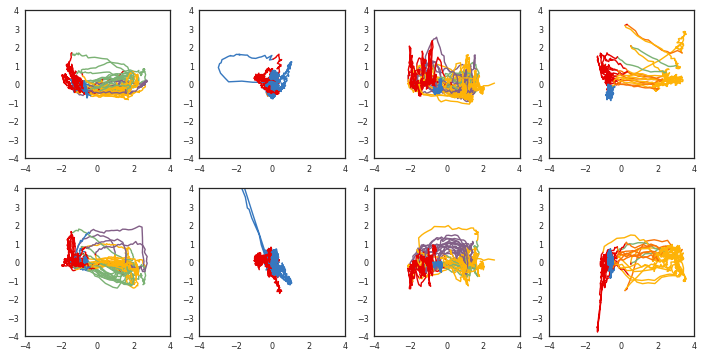

In [11]:
w_to_plot = np.array([0, 11, 23, 33])
plt.figure(figsize=(12, 6))
for i, w in enumerate(w_to_plot): 
    ax = plt.subplot(2, 4, i+1)
    zplt.plot_2d_continuous_states(xs[w], z_trues[w], xlims=(-4, 4), ylims=(-4, 4), inds=(0, 1), ax=ax)
    
    ax = plt.subplot(2, 4, 4 + i+1)
    zplt.plot_2d_continuous_states(xs[w], z_trues[w], xlims=(-4, 4), ylims=(-4, 4), inds=(0, 2), ax=ax)

# Factor Analysis

In [12]:
# # Fit a test model
# def fit_factor_analysis(D, num_gibbs_iters=20, num_em_iters=100):
    
#     # Special case D == 0
#     if D == 0:
#         mu = np.zeros(N)
#         Sigma = np.diag(np.nanvar(np.vstack(train_ys), axis=0))
        
#         lp = 0
#         for y, m in zip(train_ys, train_ms):
#             mu_i = mu[m[0]]
#             Sigma_i = Sigma[np.ix_(m[0], m[0])]
#             lp += np.sum(multivariate_normal.logpdf(y[:, m[0]], mu_i, Sigma_i))
        
#         val_ll = 0
#         for y, m in zip(val_ys, val_ms):
#             mu_i = mu[m[0]]
#             Sigma_i = Sigma[np.ix_(m[0], m[0])]
#             val_ll += np.sum(multivariate_normal.logpdf(y[:, m[0]], mu_i, Sigma_i))
        
#         return Sigma, np.array([lp]), val_ll
        
#     # For D > 1, fit a factor analysis model
#     from pybasicbayes.models import FactorAnalysis
#     fa = FactorAnalysis(N, D)
#     for y, m in zip(train_ys, train_ms):
#         fa.add_data(y, mask=m.astype(bool))

#     lps = []
#     for _ in tqdm(range((num_gibbs_iters))):
#         fa.resample_model()
#         lps.append(fa.log_likelihood())

#     for _ in tqdm(range((num_em_iters))):
#         fa.EM_step()
#         lps.append(fa.log_likelihood())

#     # Compute marginal likelihood of validation data
#     mu = np.zeros(N)
#     Sigma = fa.W.dot(fa.W.T) + np.diag(fa.sigmasq)
    
#     val_ll = 0
#     for y, m in zip(val_ys, val_ms):
#         m0 = m[0]
#         mu_i = mu[m0]
#         Sigma_i = Sigma[np.ix_(m0, m0)]
#         vll = multivariate_normal.logpdf(y[:, m0], mu_i, Sigma_i)
#         assert vll.shape == (y.shape[0],)
#         val_ll += np.sum(vll)
    
#     return fa, lps, val_ll

# Ds = np.arange(0, 21)
# fas = []
# lpss = []
# val_lls = []
# for D in Ds:
#     print("Fitting FA with D=", D)
#     _fa = cached(results_dir, "fa_D{}".format(D))(fit_factor_analysis)
#     fa, lps, val_ll = _fa(D)
#     fas.append(fa)
#     lpss.append(lps)
#     val_lls.append(val_ll)

In [13]:
# for D, lps in zip(Ds, lpss):
#     plt.plot(lps, label="D={}".format(D))
# #     plt.xlim(21, 120)
# plt.legend()

# plt.figure()
# plt.plot(Ds, val_lls)
# ll_95 = np.min(val_lls[1:]) + 0.95 * (np.max(val_lls) - np.min(val_lls[1:]))
# plt.plot(Ds, ll_95 * np.ones_like(Ds), ':k')
# plt.legend()

In [14]:
# # Find an orthogonal emission matrix from the factor analysis loadings
# C_fa = fa.W
# Sigma = np.dot(C_fa, C_fa.T) + np.diag(fa.sigmasq)
# evals, evecs = np.linalg.eigh(Sigma, )
# inds = np.argsort(evals)[::-1][:D]
# Cstar_fa = evecs[:, inds]

# # Find the linear transformation that maps C to Cstar
# #    Cstar = C \dot R
# #    Cstar R^{-1} = C
# #    y = Cx = Cstar R^{-1} x
# R, _, _, _ = np.linalg.lstsq(C_fa, Cstar_fa)
# Ri = np.linalg.inv(R)

# # Counter rotate the continuous latent states
# xs_fa = [d.Z.dot(Ri.T) for d in fa.data_list]

# # Compute the correlation under the FA model
# Cn_fa = C_fa / np.linalg.norm(C_fa, ord=2, axis=1, keepdims=True)
# fa_corr = Cn_fa.dot(Cn_fa.T)

In [15]:
# w_to_plot = np.array([0, 11, 23, 33])
# plt.figure(figsize=(12, 6))
# for i, w in enumerate(w_to_plot): 
#     ax = plt.subplot(2, 4, i+1)
#     zplt.plot_2d_continuous_states(xs_fa[w], z_trues[w], xlims=(-4, 4), ylims=(-4, 4), inds=(0, 1), ax=ax)
    
#     ax = plt.subplot(2, 4, 4 + i+1)
#     zplt.plot_2d_continuous_states(xs_fa[w], z_trues[w], xlims=(-4, 4), ylims=(-4, 4), inds=(0, 2), ax=ax)

# Cluster the neurons on the basis of their latent state tuning

In [84]:
def cluster_neurons(C_norm, N_clusters, seed):
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score, calinski_harabaz_score
    from sklearn.metrics import davies_bouldin_score
    from sklearn.decomposition import PCA
    from pyhsmm.util.general import relabel_by_permutation
    
    # Perform the clustering
    np.random.seed(seed)    
    cluster = KMeans(n_clusters=N_clusters)
    cluster.fit(C_norm)
    neuron_clusters = cluster.labels_

    # Compute some clustering metrics
    sil_score = silhouette_score(C_norm, neuron_clusters, metric='cosine')
    ch_score = calinski_harabaz_score(C_norm, neuron_clusters)
    
#     try:
#         db_score = davies_bouldin_score(C_norm, neuron_clusters)  
#     except Exception as e:
#         db_score = np.nan
    db_score = np.nan
    
    # Reorder the clusters according to average tuning within cluster
    avg_C = np.zeros((N_clusters, D))
    for c in range(N_clusters):
        if not np.any(neuron_clusters == c):
            continue
        avg_C[c] = np.mean(C_norm[neuron_clusters == c], axis=0)

    # Sort the clusters by their projection onto the first principal component
    pca = PCA(n_components=1, random_state=0, svd_solver="full")
    pca.fit(avg_C)
    weights = pca.transform(avg_C)[:, 0]
    weights *= np.sign(weights[0])

    labels_perm = np.argsort(weights)
    neuron_clusters = relabel_by_permutation(neuron_clusters, np.argsort(labels_perm))

    # Lex sort by label then by emission vector
    # perm = np.lexsort(np.row_stack((C_true.T, labels)))
    neuron_perm = np.lexsort((neuron_names, neuron_clusters))
    
    return neuron_perm, neuron_clusters, sil_score, ch_score, db_score

In [85]:
sil_scores = []
ch_scores = []
db_scores = []
Ks = np.arange(2, 21)
N_repeats = 50
for K in Ks:
    sil_scores_K = []
    ch_scores_K = []
    db_scores_K = []
    for rpt in range(N_repeats):
        _cluster = cached(os.path.join(results_dir, "kmeans"), "kmeans_K{}_rpt{}".format(K, rpt))(cluster_neurons)
        _, _, sil_score, ch_score, db_score = _cluster(Cn_pca, K, seed=rpt)
        sil_scores_K.append(sil_score)
        ch_scores_K.append(ch_score)
        db_scores_K.append(db_score)
    
    sil_scores.append(sil_scores_K)
    ch_scores.append(ch_scores_K)
    db_scores.append(db_scores_K)
    
# Compute mean and variance
mean_sil_scores = [np.mean(ss) for ss in sil_scores]
std_sil_scores = [np.std(ss) for ss in sil_scores]
mean_ch_scores = [np.mean(chs) for chs in ch_scores]
std_ch_scores = [np.std(chs) for chs in ch_scores]
mean_db_scores = [np.mean(dbs) for dbs in db_scores]
std_db_scores = [np.std(dbs) for dbs in db_scores]

In [86]:
std_sil_scores

[5.551115123125783e-17,
 0.00496249232512396,
 0.004089982495675423,
 0.02853942198837778,
 0.033296071565611936,
 0.034351247967812436,
 0.02898312876881186,
 0.030589528681576647,
 0.022587097707036836,
 0.023359730196480997,
 0.0368803162653578,
 0.03180930102755072,
 0.03746833765712033,
 0.03650174804612886,
 0.03179465848151782,
 0.025119367034570163,
 0.02085219250556504,
 0.018485445662519518,
 0.018261728394013108]

Text(0.5,1,'DB Score (higher = better)')

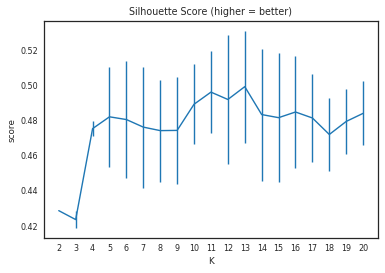

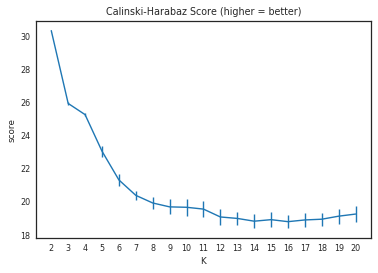

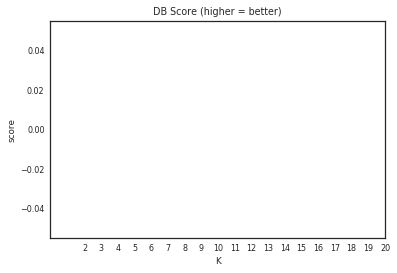

In [87]:
plt.figure()
plt.errorbar(Ks, mean_sil_scores, yerr=std_sil_scores)
plt.xlabel("K")
plt.xticks(Ks)
plt.ylabel("score")
plt.title("Silhouette Score (higher = better)")

plt.figure()
plt.errorbar(Ks, mean_ch_scores, yerr=std_ch_scores)
plt.xlabel("K")
plt.xticks(Ks)
plt.ylabel("score")
plt.title("Calinski-Harabaz Score (higher = better)")

plt.figure()
plt.errorbar(Ks, mean_db_scores, yerr=std_db_scores)
plt.xlabel("K")
plt.xticks(Ks)
plt.ylabel("score")
plt.title("DB Score (higher = better)")

In [88]:
best_K = 13
rpt = 1
_cluster = cached(os.path.join(results_dir, "kmeans"), "kmeans_K{}_rpt{}".format(best_K, rpt))(cluster_neurons)
perm, clusters, _, _, _ = _cluster(Cn_pca, best_K, seed=rpt)
divs = np.cumsum(np.bincount(clusters, minlength=best_K))

(73, 0)

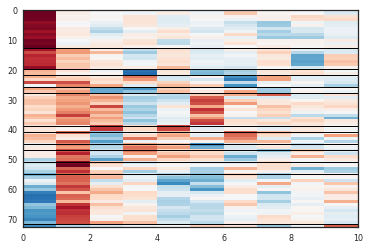

In [89]:
lim = abs(Cn_pca).max()
plt.imshow(Cn_pca[perm], aspect="auto", vmin=-lim, vmax=lim, cmap="RdBu_r", extent=(0, D, N, 0))
for div in divs:
    plt.plot([0, D], [div, div], '-k', lw=1)
plt.xlim(0, D)
plt.ylim(N, 0)

In [90]:
# def _plot_corr(ax, corr, cmap):
#     im = plt.imshow(corr[np.ix_(perm, perm)], cmap=cmap, vmin=-1, vmax=1, extent=(0, N, N, 0))
#     for div in divs:
#         plt.plot([0, N], [div, div], '-k', lw=1)
#         plt.plot([div, div], [0, N], '-k', lw=1)
#     plt.xlim(0, N)
#     plt.ylim(N, 0)
#     return im

# cmap = matplotlib.cm.RdBu_r
# cmap.set_bad('gray',1.)

# plt.figure(figsize=(12, 5))
# ax = plt.subplot(131)
# im = _plot_corr(ax, emp_corr, cmap)
# plt.title("Empirical Correlation")

# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=.1)
# plt.colorbar(im, cax=cax)


# ax = plt.subplot(132)
# im = _plot_corr(ax, pca_corr, cmap)
# plt.title("PCA Correlation")

# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.1)
# plt.colorbar(im, cax=cax)

# ax = plt.subplot(133)
# im = _plot_corr(ax, fa_corr, cmap)
# plt.title("FA Correlation")

# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.1)
# plt.colorbar(im, cax=cax)


In [91]:
for k in range(best_K):
    print("Cluster ", k)
    for name in [name for kn, name in zip(clusters, neuron_names) if kn == k]:
        print(name)
        
    print("")

Cluster  0
AIBL
AIBR
AVAL
AVAR
AVEL
AVER
OLQDL
OLQDR
OLQVL
OLQVR
RIML
RIMR
VA01

Cluster  1
SABVL
SABVR
URYDL
URYDR
URYVL
URYVR
VA02

Cluster  2
RIVL
RIVR

Cluster  3
ASGL
ASGR
ASKR
SMBVL

Cluster  4
SMDVL
SMDVR

Cluster  5
ALA
AQR
AUAL
AUAR
IL2DL
IL2DR
IL2L
RMGL
RMGR
URXL
URXR

Cluster  6
SMDDL
SMDDR

Cluster  7
AWBL
AWCL
AWCR
RIFR

Cluster  8
BAGL
BAGR

Cluster  9
AFDL
AFDR
ASKL
RIFL

Cluster  10
AVFL
AVFR
AWAL
RID

Cluster  11
AVBL
AVBR
DB01
DB02
RIBL
RIBR
RMED
RMEL
RMER
RMEV
SIBDL
SIBDR
SIBVL
SIBVR
VB01
VB02
VB03

Cluster  12
RIS



# Load per neuron location, type, functional type dat

In [208]:
import pandas as pd

neuron_locations_csv = pd.read_csv("~/Projects/zimmer/wormatlas_locations.csv")
neuron_locations = [np.array(neuron_locations_csv[neuron_locations_csv.name == name].location)[0] 
                    for name in neuron_names]
neuron_locations = np.array(neuron_locations)

In [209]:
neuron_celltypes_csv = pd.read_csv("~/Projects/zimmer/wormatlas_celltypes.csv")
neuron_celltypes = []
for name in neuron_names:
    neuron_celltypes.append(np.array(neuron_celltypes_csv[neuron_celltypes_csv.name == name].type)[0])
neuron_celltypes = np.array(neuron_celltypes)

In [210]:
neuron_functions_csv = pd.read_csv("~/Projects/zimmer/neuron_functions.csv")
functions = ['Fwd', 'Rev', 'FwdRev', 'DT', 'VT', 'Other', 'Quiescence', 'FwdQui']
neuron_functions = []
for name in neuron_names:
    row = neuron_functions_csv[neuron_functions_csv.Name == name]
    assert len(row) == 1
    for f in functions:
        if np.array(row[f])[0] == 1:
            neuron_functions.append(f)
neuron_functions = np.array(neuron_functions)

# Make Figure 2: C matrix, Raw Correlation, Estimated Correlation

In [92]:
def _plot_corr(ax, corr, cmap):
    im = plt.imshow(corr[np.ix_(perm, perm)], cmap=cmap, vmin=-1, vmax=1, extent=(0, N, N, 0), aspect="auto")
    for div in divs:
        plt.plot([0, N], [div, div], '-k', lw=1)
        plt.plot([div, div], [0, N], '-k', lw=1)
    plt.xlim(0, N)
    plt.ylim(N, 0)
    return im

In [249]:
from hips.plotting.layout import create_axis_at_location

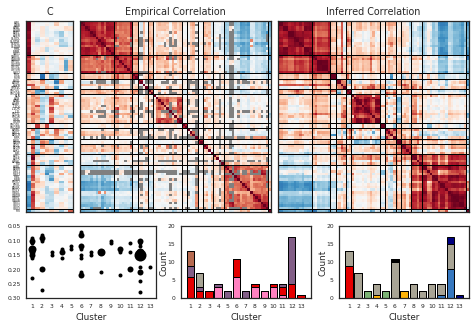

In [274]:
cmap = matplotlib.cm.RdBu_r
cmap.set_bad('gray',1.)

# Make plot
fig = plt.figure(figsize=(6.5, 4.5))
fig.patch.set_alpha(0)
# gs = GridSpec(2, 15, height_ratios=[3, 1])

# Plot C
lim = abs(Cn_pca).max()
ax = create_axis_at_location(fig, .25, 1.6, .65, 2.65)
plt.imshow(Cn_pca[perm], vmin=-lim, vmax=lim, cmap="RdBu_r", extent=(0, D, N, 0), aspect="auto")
for div in divs:
    plt.plot([0, D], [div, div], '-k', lw=1)
plt.xlim(0, D)
plt.xticks([])
plt.ylim(N, 0)
plt.yticks(np.arange(N)+.5, neuron_names[perm], fontsize=3)
# plt.yticks([])
plt.title("C")

# Plot empirical correlation
ax = create_axis_at_location(fig, 1, 1.6, 2.65, 2.65)
im = _plot_corr(ax, emp_corr, cmap)
ax.set_xticks([])
ax.set_yticks([])
plt.title("Empirical Correlation")

# Plot model correlation
ax = create_axis_at_location(fig, 3.75, 1.6, 2.65, 2.65)
im = _plot_corr(ax, pca_corr, cmap)
ax.set_xticks([])
ax.set_yticks([])
plt.title("Inferred Correlation")

# Cluster locations
ax = create_axis_at_location(fig, .25, .4, 1.8, 1.)
location_bins = np.arange(neuron_locations.min(), neuron_locations.max()+.01, .01)
for k in range(best_K):
    locs_k, _ = np.histogram([l for l, c in zip(neuron_locations, clusters) if c == k], location_bins)
    
    for b, count in zip(location_bins, locs_k):
        if count > 0:
            plt.plot(k, b, 'ko', markersize=2 + 2 * count)
        
plt.xticks(np.arange(best_K), np.arange(1, best_K + 1), fontsize=6)
plt.xlabel("Cluster")
plt.yticks(np.arange(0.05, 0.31, 0.05), fontsize=6)
plt.ylim(.30, .05)

# Cluster cell types
colors = [zplt.default_colors[7], zplt.default_colors[1], zplt.default_colors[4], zplt.default_colors[6], zplt.default_colors[8]]
ax = create_axis_at_location(fig, 2.4, .4, 1.8, 1.)
for k in range(best_K):
    offset = 0
    for i, t in enumerate(['S', 'I', 'M', 'P', 'U']):
        count = np.sum(neuron_celltypes[clusters == k] == t)
        plt.bar(k, count, width=.8, bottom=offset, color=colors[i], edgecolor='k', linewidth=1)
        offset += count
        
plt.xticks(np.arange(best_K), np.arange(1, best_K + 1), fontsize=6)
plt.xlabel("Cluster")
plt.yticks(np.arange(0, 21, 5), fontsize=6)
plt.ylabel("Count", labelpad=-1)
plt.ylim(0, 20)

# Cluster functional types
ax = create_axis_at_location(fig, 4.6, .4, 1.8, 1.)
functions = ['Fwd', 'Rev', 'FwdRev', 'DT', 'VT', 'Other', 'Quiescence', 'FwdQui']
colors = [zplt.default_colors[0], # fwd = blue
          zplt.default_colors[1], # rev = red
          zplt.default_colors[4], # fwd/rev = purple
          zplt.default_colors[2], # dt = yellow
          zplt.default_colors[3], # vt = Green
          zplt.default_colors[8], # other = Grey
          'black',                # quiescence = black
          'navy',                 # fwdqui = navy
         ]
for k in range(best_K):
    offset = 0
    for i, t in enumerate(functions):
        count = np.sum(neuron_functions[clusters == k] == t)
        plt.bar(k, count, width=.8, bottom=offset, color=colors[i], edgecolor='k', linewidth=1)
        offset += count

plt.xticks(np.arange(best_K), np.arange(1, best_K + 1), fontsize=6)
plt.xlabel("Cluster")
plt.yticks(np.arange(0, 21, 5), fontsize=6)
plt.ylabel("Count", labelpad=-1)
plt.ylim(0, 20)


figname = "clustering"
plt.savefig(os.path.join(figures_dir, figname + ".png"), dpi=300)
plt.savefig(os.path.join(figures_dir, figname + ".pdf"))